## Analysis of short-reads scRNA-seq (first pass)

This notebook is a first-pass analysis of a tumor-infiltrating T cell sample to identify tumor and immune components.

**Notes**
- The sample is referred to as `M132TS` in various places.
- It turns out that this sample contains a sizable tumor component (MLANA+). As such, we will separate the dataset into immune and non-immune components for separate analysis.
- This sample is sorted for CD45+, CD8+, CD3+

**Inputs and Outputs**
- Inputs:
  - `raw_feature_bc_matrix.h5`: raw counts from 10x cellranger counts pipeline for sample M132TS
- Outputs:
  - `M132TS_full.hd5ad`: an AnnData object object containing filtered cells (immune and tumor)
  - `M132TS_immune_barcodes.npy`: list of immune cell barcodes
  - `M132TS_tumor_barcodes.npy`: list of tumor cell barcodes  

In [48]:
%matplotlib inline

import matplotlib.pylab as plt

import numpy as np
import pandas as pd
import os
import sys
from time import time
import logging
import pickle

import scanpy as sc

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = logger.warning

import warnings
warnings.filterwarnings("ignore")

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
sc.__version__

'1.7.2'

In [3]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'
m132ts_h5_path = 'data/t-cell-vdj/M132TS/raw_feature_bc_matrix.h5'
m132ts_h5ad_out_path = 'M132TS_full.h5ad'

output_root = os.path.join(repo_root, 'output/t-cell-vdj-cite-seq')
m132ts_h5_full_path = os.path.join(repo_root, m132ts_h5_path)
m132ts_h5ad_out_full_path = os.path.join(repo_root, m132ts_h5ad_out_path)

h5_full_path = m132ts_h5_full_path
h5ad_out_full_path = m132ts_h5ad_out_full_path

os.makedirs(output_root, exist_ok=True)

In [4]:
adata = sc.read_10x_h5(h5_full_path, gex_only=False)
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata.var

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC007325.2,ENSG00000277196,Gene Expression,GRCh38
CD45_TotalSeqC,CD45,Antibody Capture,
CD45R_B220_TotalSeqC,CD45R_B220,Antibody Capture,
CD45RA_TotalSeqC,CD45RA,Antibody Capture,


In [6]:
adata.obs.head()

""
AAACCTGAGAAACCAT-1
AAACCTGAGAAACCGC-1
AAACCTGAGAAACCTA-1
AAACCTGAGAAACGAG-1
AAACCTGAGAAACGCC-1


In [7]:
# remove '-1' suffixed from barcodes
def remove_barcode_suffix(barcode: str, delimiter='-') -> str:
    return barcode.split(delimiter)[0]
adata.obs.index = np.asarray(list(map(remove_barcode_suffix, adata.obs.index.values)))

In [8]:
adata.obs.head()

""
AAACCTGAGAAACCAT
AAACCTGAGAAACCGC
AAACCTGAGAAACCTA
AAACCTGAGAAACGAG
AAACCTGAGAAACGCC


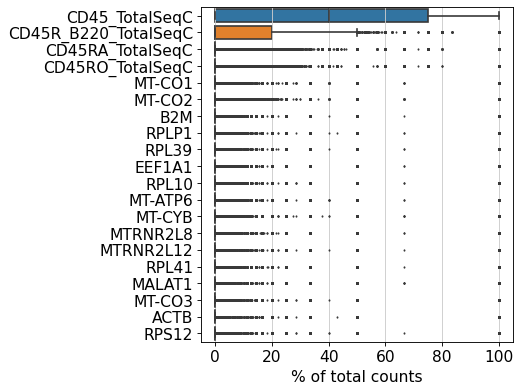

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [10]:
adata

AnnData object with n_obs × n_vars = 737280 × 36605
    var: 'gene_ids', 'feature_types', 'genome'

In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['antibody_feature'] = (adata.var.feature_types == 'Antibody Capture')

In [12]:
# add log(1 + antibody counts) as 'obs' annotations for each cell
adata_ab = adata[:, adata.var['antibody_feature']]
ab_list = list(adata_ab.var.index.values)
for ab_idx, ab in enumerate(ab_list):
    adata.obs[ab] = \
        np.log1p(np.asarray(adata_ab.X[:, ab_idx].todense()).squeeze())
    
# remove antibody counts from variables
adata = adata[:, ~adata.var['antibody_feature']]

In [13]:
adata.obs

,CD45_TotalSeqC,CD45R_B220_TotalSeqC,CD45RA_TotalSeqC,CD45RO_TotalSeqC
AAACCTGAGAAACCAT,0.693147,0.693147,0.0,0.0
AAACCTGAGAAACCGC,0.693147,0.000000,0.0,0.0
AAACCTGAGAAACCTA,0.000000,0.000000,0.0,0.0
AAACCTGAGAAACGAG,0.693147,0.000000,0.0,0.0
AAACCTGAGAAACGCC,0.000000,0.000000,0.0,0.0
...,...,...,...,...
TTTGTCATCTTTACAC,1.098612,0.000000,0.0,0.0
TTTGTCATCTTTACGT,0.693147,0.693147,0.0,0.0
TTTGTCATCTTTAGGG,0.000000,0.000000,0.0,0.0
TTTGTCATCTTTAGTC,1.386294,0.693147,0.0,0.0


In [14]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Trying to set attribute `.obs` of view, copying.


In [15]:
adata

AnnData object with n_obs × n_vars = 737280 × 36601
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'antibody_feature', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [16]:
# from cellranger
total_reads = 171388351
reads_per_umi = total_reads / adata.X.sum()

In [17]:
print (f'Number of reads per UMI for short-reads dataset: {reads_per_umi:.3f}')

Number of reads per UMI for short-reads dataset: 3.715


In [18]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=3)

In [19]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


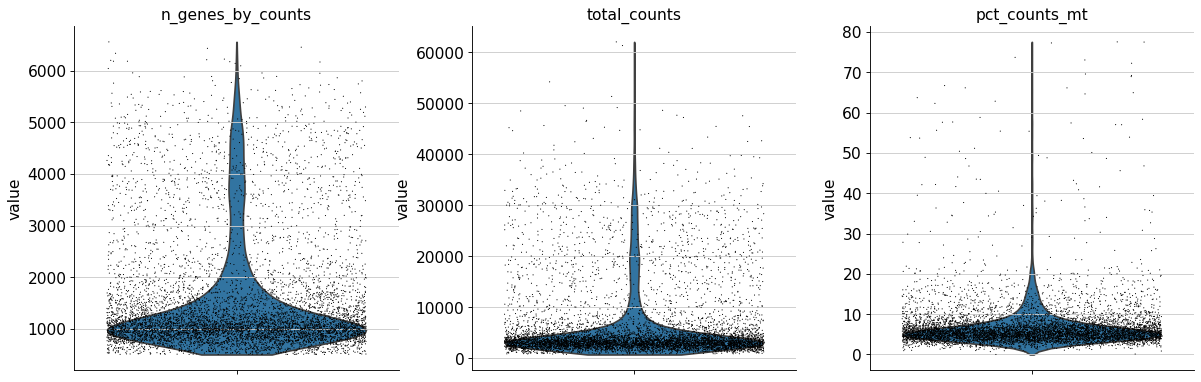

In [20]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

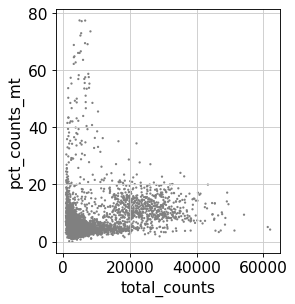

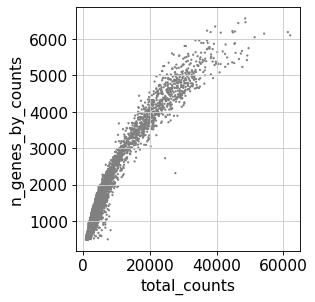

In [21]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Note: interesting bimodality in the `pct_counts_mt` vs. `total_counts` plot; probably dealing with two major clusters

In [22]:
# remove droplets with too many genes (a heuristic way of removing multiplets)
# adata = adata[adata.obs.n_genes_by_counts < 5000, :]

# removes droplets with too many MT genes (a heuristic way of removing dead cells)
adata = adata[adata.obs.pct_counts_mt < 20, :]

Trying to set attribute `.obs` of view, copying.


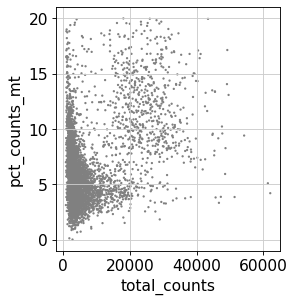

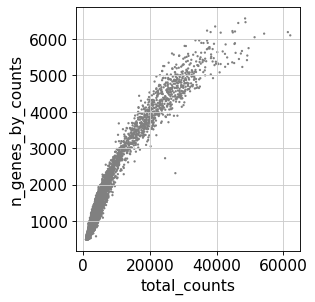

In [23]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [24]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [25]:
sc.pp.log1p(adata)

In [26]:
adata

AnnData object with n_obs × n_vars = 7071 × 19010
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'antibody_feature', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'

## Dimensionality reduction

In [27]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

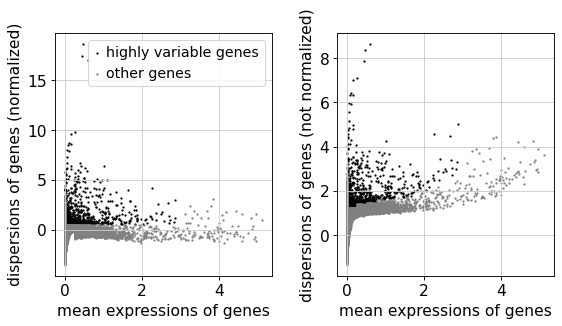

In [28]:
sc.pl.highly_variable_genes(adata)

In [29]:
adata.raw = adata

In [30]:
# keep genes that are highly variable
adata = adata[:, adata.var.highly_variable]

In [31]:
sc.pp.scale(adata, max_value=10)

In [32]:
sc.tl.pca(adata, svd_solver='arpack')

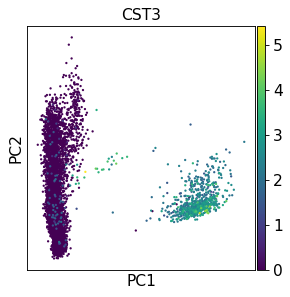

In [33]:
sc.pl.pca(adata, color='CST3')

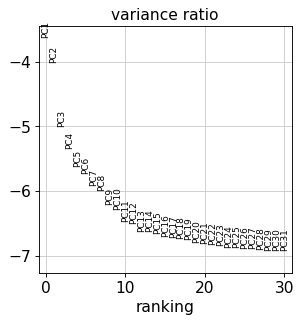

In [34]:
sc.pl.pca_variance_ratio(adata, log=True)

In [35]:
adata

AnnData object with n_obs × n_vars = 7071 × 2868
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'antibody_feature', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [36]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

In [37]:
sc.tl.umap(adata)

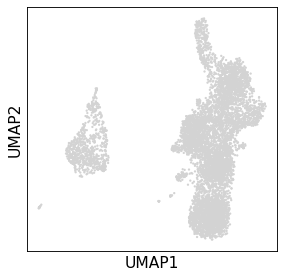

In [38]:
sc.pl.umap(adata)

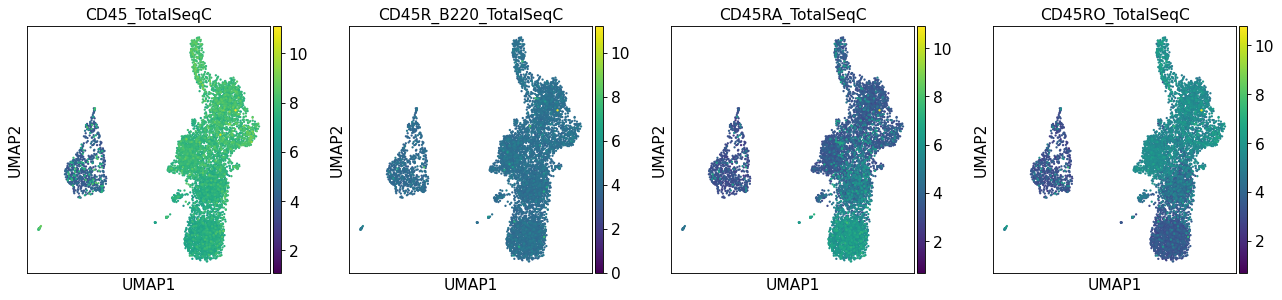

In [39]:
sc.pl.umap(adata, color=['CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC'])

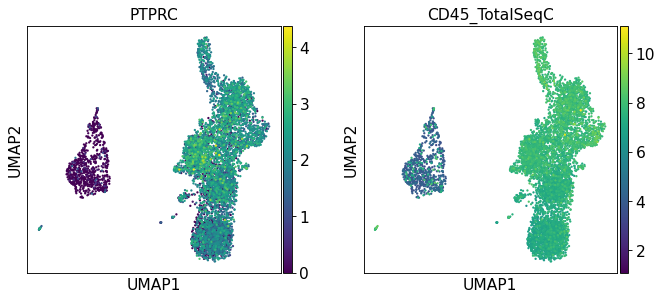

In [40]:
sc.pl.umap(adata, color=['PTPRC', 'CD45_TotalSeqC'])

Text(0, 0.5, 'CD45 AB (log)')

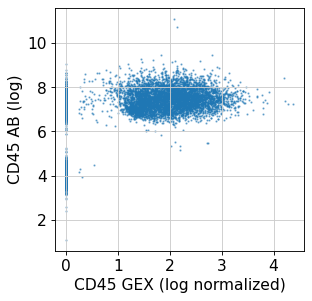

In [41]:
# make a scatter plot of CD45 GEX vs. AB
CD45_gex = np.asarray(adata.raw.X[:, adata.raw.var.index.values == 'PTPRC'].todense()).flatten()
CD45_ab = adata.obs['CD45_TotalSeqC'].values.flatten()
plt.scatter(CD45_gex, CD45_ab, s=1, alpha=0.5)
plt.xlabel('CD45 GEX (log normalized)')
plt.ylabel('CD45 AB (log)')

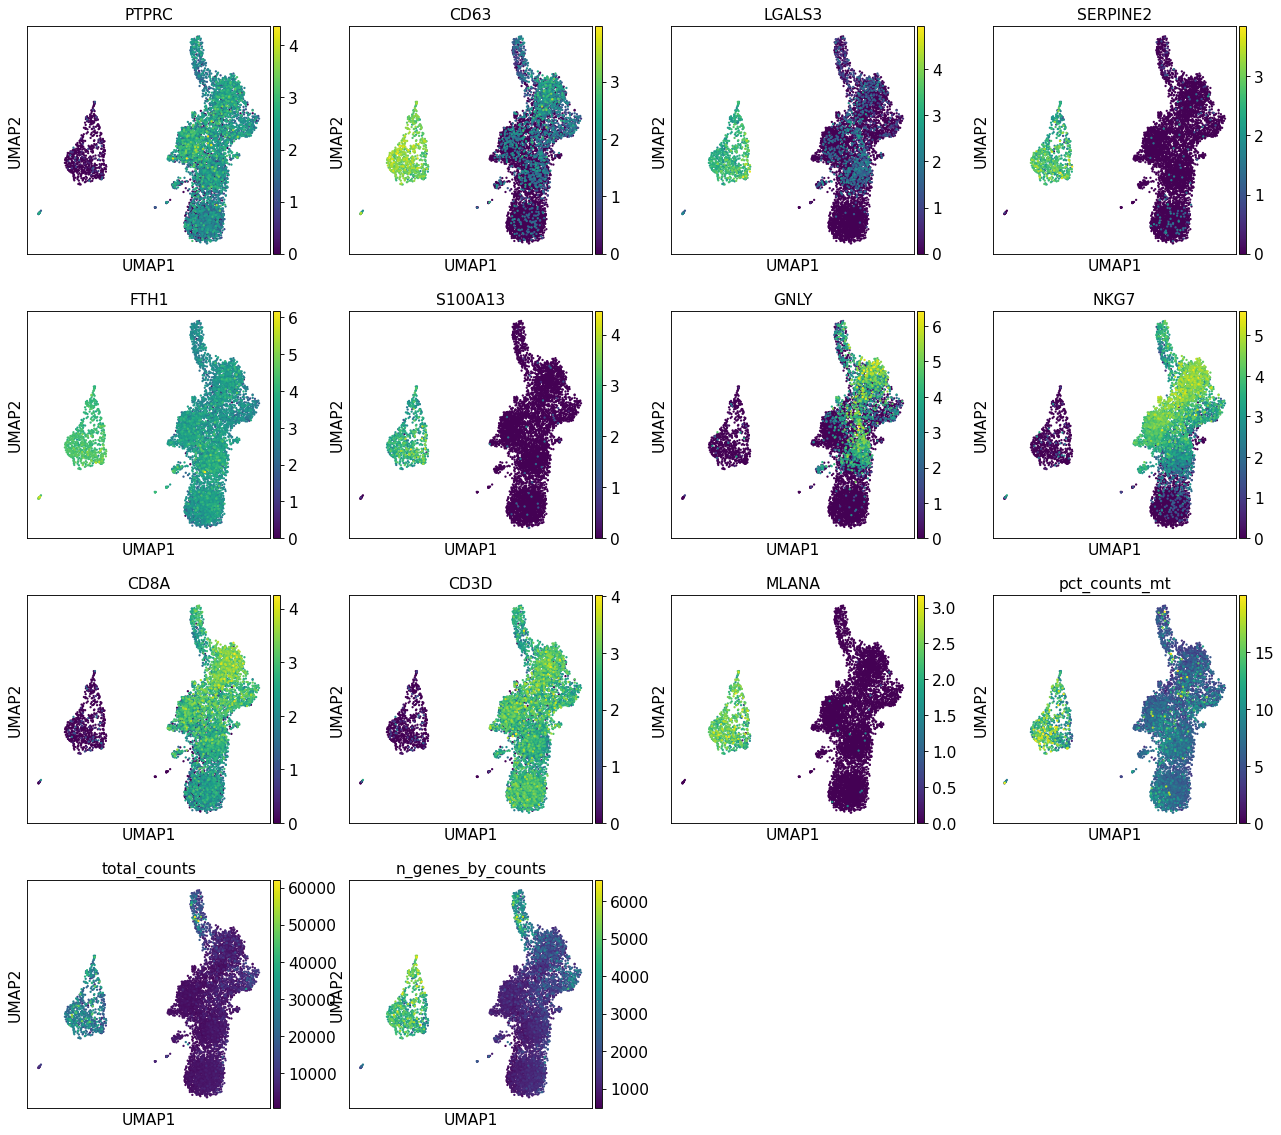

In [42]:
sc.pl.umap(
    adata,
    color=['PTPRC', 'CD63', 'LGALS3', 'SERPINE2', 'FTH1', 'S100A13', 'GNLY', 'NKG7', 'CD8A', 'CD3D', 'MLANA',
            'pct_counts_mt', 'total_counts', 'n_genes_by_counts'])

In [43]:
sc.tl.leiden(adata, resolution=0.5)

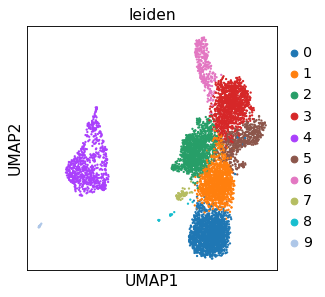

In [44]:
sc.pl.umap(adata, color=['leiden'])

In [45]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

## Separate immune and tumor components

In [46]:
m132ts_h5_full_path = os.path.join(repo_root, m132ts_h5_path)
m132ts_h5ad_out_full_path = os.path.join(repo_root, m132ts_h5ad_out_path)

cluster_map = {
    ('0', '1', '2', '3', '5', '6', '7'): 'immune',
    ('4', '8'): 'tumor'
}

for leiden_ids, desc in cluster_map.items():
    barcode_array = adata[adata.obs['leiden'].isin(leiden_ids)].obs.index.values
    print(f'{desc}: {len(barcode_array)}')
    barcode_output_file = os.path.join(
        repo_root, f'output/t-cell-vdj-cite-seq/M132TS_{desc}_barcodes.npy')
    np.save(barcode_output_file, barcode_array, allow_pickle=True)

immune: 6332
tumor: 722


In [47]:
adata.write(h5ad_out_full_path)